## spell check

In [2]:
import numpy as np
import pandas as pd 
import os 

In [3]:
data_path = 'dataset/Metal_Content_of_Consumer_Products_Tested_by_the_NYC_Health_Department_20240403.csv'
df = pd.read_csv(data_path)

In [ ]:
!pip3 install pandas pyspellchecker
from spellchecker import SpellChecker

spell = SpellChecker()

def find_misspellings(text):
    # Split the text into words and check each word
    words = text.split()
    misspelled = spell.unknown(words)
    return [word for word in misspelled]

# Assuming the text data is in a column named 'Description'
df['Misspelled_Words'] = df['Description'].apply(find_misspellings)


In [4]:
def read_glove_vecs(glove_file):
    with open(glove_file,'r') as f:
        words=set()
        for line in f:
            line=line.strip().split()
            curr_word=line[0]
            words.add(curr_word)
        i=1
        words_to_index={}
        for w in sorted(words):
            words_to_index[w]=i
            i=i+1
    del words
    return words_to_index

In [20]:
WORDS=read_glove_vecs('dataset/glove.6B.50d.txt')

In [23]:
import re 
from collections import Counter
def words(text):
    return re.findall(r'\w+', text.lower())
def P(word):
    return -WORDS.get(word,0)
def correction(word):
    return max(candidates(word), key=P)
def candidates(word):
    c =  (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])
    return c
def known(ws):
    return set(w for w in ws if w in WORDS)
def edits1(word):
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)
def edits2(word):
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [30]:
df

,ROW_ID,PRODUCT_TYPE,PRODUCT_NAME,METAL,CONCENTRATION,UNITS,MANUFACTURER,MADE_IN_COUNTRY,COLLECTION_DATE,DELETED
0,1,Food-Spice,Turmeric powder,Lead,2.9,ppm,UNKNOWN OR NOT STATED,INDIA,01/04/2011 12:00:00 AM,NaN
1,2,Food-Spice,Cumin powder,Lead,2.4,ppm,UNKNOWN OR NOT STATED,INDIA,01/04/2011 12:00:00 AM,NaN
2,3,Food-Spice,Cumin seeds,Lead,2.8,ppm,UNKNOWN OR NOT STATED,INDIA,01/04/2011 12:00:00 AM,NaN
3,4,Food-Spice,Masala,Lead,12.0,ppm,UNKNOWN OR NOT STATED,UNKNOWN OR NOT STATED,01/04/2011 12:00:00 AM,NaN
4,5,Food-Candy,Tamarind Candy,Lead,-1.0,ppm,UNKNOWN OR NOT STATED,UNKNOWN OR NOT STATED,01/06/2011 12:00:00 AM,NaN
...,...,...,...,...,...,...,...,...,...,...
6888,6889,Other,Mogra Incense Sticks,Lead,1.9,ppm,Hem Corporation,INDIA,12/20/2022 12:00:00 AM,NaN
6889,6890,Food Other,Home made ground cereal,Lead,26.0,ppm,UNKNOWN OR NOT STATED,UNKNOWN OR NOT STATED,12/20/2022 12:00:00 AM,NaN
6890,6891,Food-Candy,Chimoy,Lead,-1.0,ppm,UNKNOWN OR NOT STATED,UNKNOWN OR NOT STATED,12/28/2022 12:00:00 AM,NaN
6891,6892,Food-Candy,Chocolate,Lead,-1.0,ppm,UNKNOWN OR NOT STATED,UNITED STATES,12/28/2022 12:00:00 AM,NaN


In [38]:
def keep_letters_spaces_single_space(s):
    cleaned = re.sub(r'[^a-zA-Z\s]', '', s)
    single_spaced = re.sub(r'\s+', ' ', cleaned)
    return single_spaced

In [43]:
import pandas as pd
import re

def find_corrections(text):
    cleaned_text = keep_letters_spaces_single_space(text)
    arr = cleaned_text.split(' ')
    corrections_list = []
    for s in arr:
        s = s.lower()
        if s and correction(s) != s:
            corrections_list.append((s, correction(s)))
    return corrections_list

corrections = []
for line in df['MANUFACTURER']:
    corrections += find_corrections(line)

corrections_df = pd.DataFrame(corrections, columns=['Error Word', 'Corrected Word'])

print(corrections_df)


    Error Word Corrected Word
0       muecas          aucas
1       ajmera          ajmer
2    prodravka       podravka
3      cetamol         ekamol
4       preema         freema
..         ...            ...
772      abido           abdo
773    harmain       haramain
774      abido           abdo
775      bhcpl           bcpl
776     unitii         unirii

[777 rows x 2 columns]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 9.8 MB/s eta 0:00:00


/var/folders/dt/c_0ljg_n3_91zr9wrh09snf40000gn/T/ipykernel_36738/4125742482.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=error_word_counts.index, x=error_word_counts.values, palette="Blues_d")


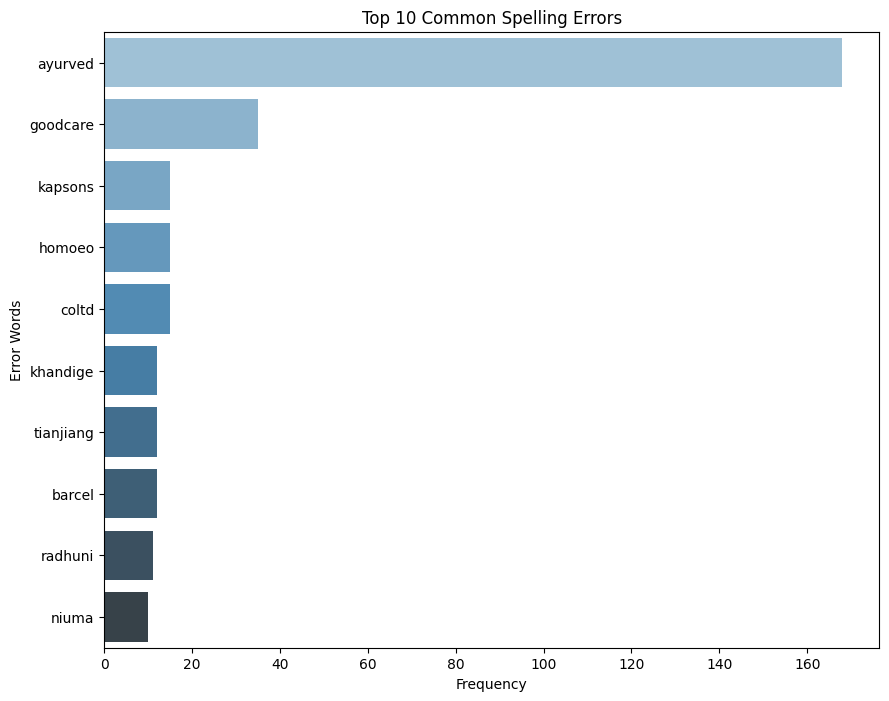

/var/folders/dt/c_0ljg_n3_91zr9wrh09snf40000gn/T/ipykernel_36738/4125742482.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=corrected_word_counts.index, x=corrected_word_counts.values, palette="Greens_d")


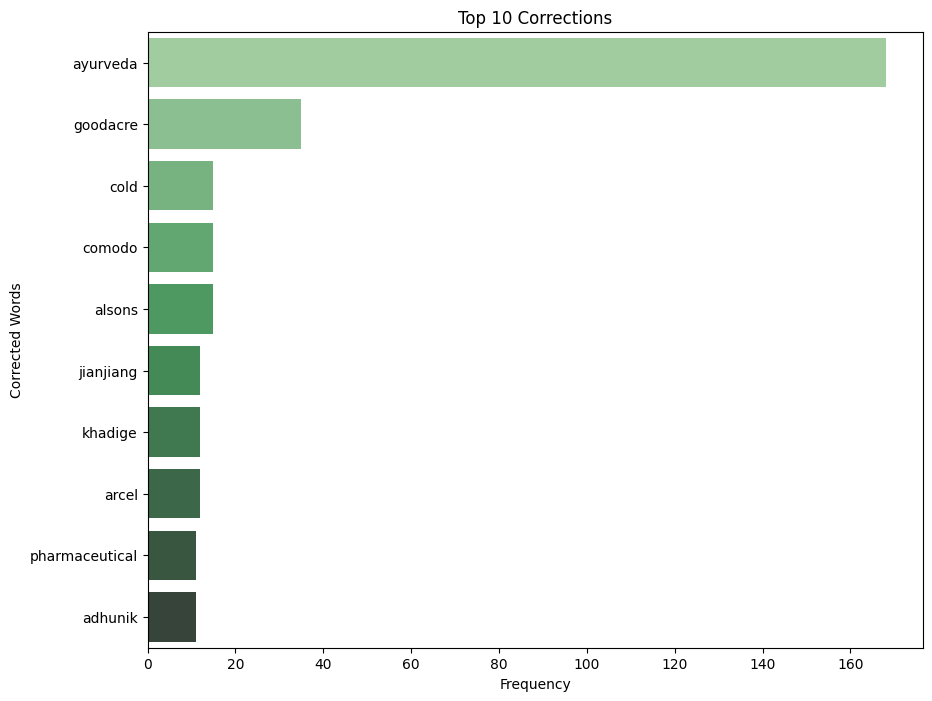

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

error_word_counts = corrections_df['Error Word'].value_counts().head(10)

corrected_word_counts = corrections_df['Corrected Word'].value_counts().head(10)

plt.figure(figsize=(10, 8))
sns.barplot(y=error_word_counts.index, x=error_word_counts.values, palette="Blues_d")
plt.title('Top 10 Common Spelling Errors')
plt.xlabel('Frequency')
plt.ylabel('Error Words')
plt.show()

plt.figure(figsize=(10, 8))
sns.barplot(y=corrected_word_counts.index, x=corrected_word_counts.values, palette="Greens_d")
plt.title('Top 10 Corrections')
plt.xlabel('Frequency')
plt.ylabel('Corrected Words')
plt.show()
